In [285]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.io.wavfile as wf

from glob import glob
from collections import deque
from zplane import *

# 0. Utils

## 0.1. Plot functions

In [286]:
def simple_plot(samples, x_values= np.array([]), plt_title= "", x_label="", y_label="", display_plot=True, save_name=None, bars : list = [], labels : list = []):
    _ = plt.figure()
    plt.title(plt_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if type(samples) != list :
        samples = [samples]
    if labels != [] and len(labels) != len(samples):
        raise Exception("Label size should be the same as the number of samples")
    
    i = 0
    for sample_data in samples:
        if len(x_values) == 0:
            if labels != []:
                plt.plot(sample_data, label=labels[i])
            else:
                plt.plot(sample_data)
        else:
            if labels != []:
                plt.plot(x_values, sample_data, label=labels[i])
            else:
                plt.plot(x_values, sample_data)
        i += 1
    if labels != []:
        plt.legend(loc="upper right")
    if bars != []:
        for bar in bars:
            # bar = 1
            plt.axvline(bar, color="gray", linestyle="--")
            pass
    if save_name != None:
        plt.savefig(save_name)
    if display_plot:
        plt.show()
    plt.close() 

In [287]:
def plot_create_sin(f, A, fs, N, bars : list = []):
    t, samples = create_sine_wave(f, A, fs, N)
    plot_sin(t, samples, bars)

def plot_sin(t, samples, bars : list = [], title=None):
    if type(t) == type(None):
        t = np.array([])
    simple_plot(samples, t, f"Sine wave" if title == None else title, "Time (sample)" if len(t) == 0 else "Time (s)", "Amplitude (V)", display_plot=True, bars=bars)

def plot_sound_wave(data, file_name: str):
    simple_plot(data, plt_title=f"Sound Wave {file_name}", x_label="Time (sample)", y_label="Amplitude (V)")


def plot_buffer_content(buffer: deque, sample_added: int, recording_time: int):
    sample_text = "sample" if sample_added == 0 else "samples"

    simple_plot(buffer, plt_title=f"Buffer contents after adding {sample_added} {sample_text} (i.e. after {recording_time} s)", 
                x_label= "Stored sample",y_label="Amplitude (s)")


def plot_filter(B_filter, A_filter, fs, name_of_filter):
    w_a, h_a = signal.freqz(B_filter, A_filter, fs= fs)
    plt.figure()
    plt.title(f"Frequency domain of the {name_of_filter} filter")
    plt.xlabel("f (Hz)")
    plt.ylabel("Amplitude (dB)")
    plt.plot(w_a, 20 * np.log10(np.abs(h_a)))
    plt.grid(which="both", axis="both")
    plt.show()
    plt.close()

In [288]:
def plot_freq_domain(data, multiple_list: bool = False, labels = [], fs=44100, title=None):
    N_data = len(data[0]) if multiple_list else len(data)


    datas_freq = []
    if multiple_list:
        for data_l in data:
            f, tmp = signal.freqz(data_l, fs=fs)
            datas_freq.append(tmp)
    else:
        f, tmp = signal.freqz(data, fs=fs)
        datas_freq = [tmp]

    data_log = []
    for data_l in datas_freq:
        data_log.append(20*np.log10(np.abs(data_l)))

    simple_plot(data_log, f, "Frequency domain" if title == None else title, "freq (Hz)", "Amplitude (dB)", labels=labels)

## 0.2. Variables

In [289]:
wp = 8000
ws = 8500
rp = 0.1
rs = 70

fs_audio = 44.1 * 1000

file_dir = "LocateClaps/"

# 1. Data generation and dataset

## 1.1. Data generation and dataset

### 1.1.1. Sine wave function

In [290]:
def create_sine_wave(f, A, fs, N):
    sampling = np.arange(0, N/fs,1/fs)
    sin_samples =  np.sin(2 * np.pi * sampling * f)
    return sampling, A * sin_samples

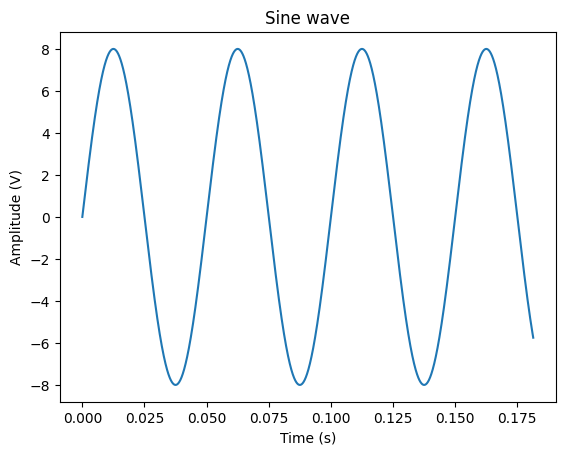

In [291]:
N = 8000

f = 20
amplitude = 8

plot_create_sin(f, amplitude, fs_audio, N)

### 1.1.2 Read Wavefile function

In [292]:
def read_wavefile(path):
    return wf.read(path)

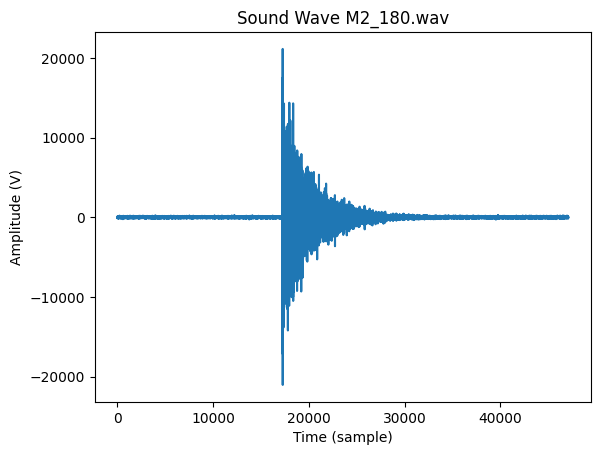

In [293]:
file_name = "M2_180.wav"

f, data1 = read_wavefile(file_dir + file_name)

plot_sound_wave(data1, file_name)

In [294]:
skip_saving = True
SavePlotFile = "SoundWavePlots/"
LocateClaps = "./LocateClaps"
files = glob(f"{LocateClaps}/*.wav")

if not skip_saving:
    for file in files:
        _, data1 = read_wavefile(file)
        file_name = file.removeprefix(LocateClaps + "/").removesuffix(".wav") # keep only the name

        simple_plot(data1, plt_title=f"Sound Wave {file_name}.wav", x_label="Time (s)", y_label="Amplitude (V)", 
                    display_plot=False, save_name=f"{SavePlotFile}/{file_name}")

## 1.2 Buffering

### 1.2.1 Create the `create_ringbuffer` function

In [295]:
def create_ringbuffer(maxlen) -> deque:
    return deque(maxlen=maxlen)

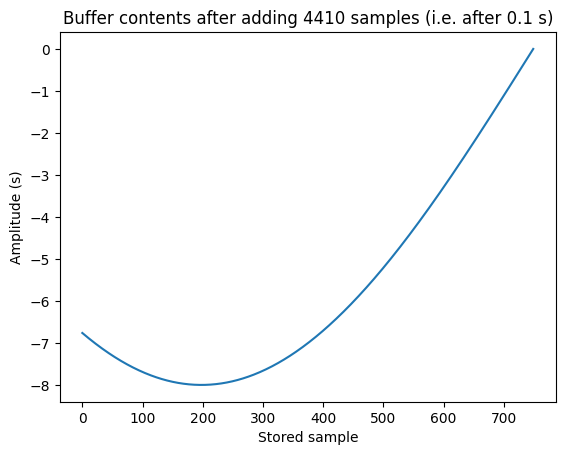

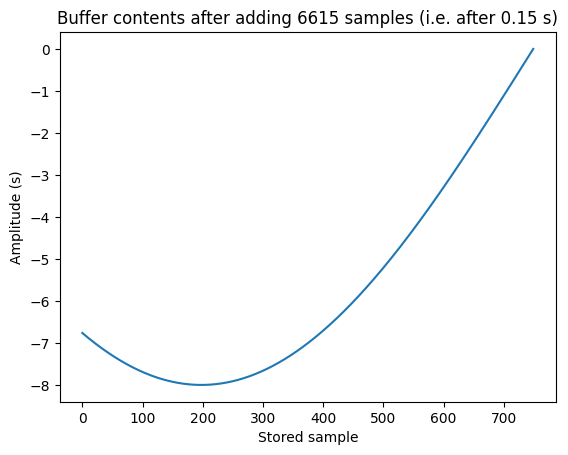

In [296]:

N = 8000

f = 20
amplitude = 8


maxlen = 750
buffer = create_ringbuffer(maxlen)

display_at_times = [0.1, 0.15]

t, samples = create_sine_wave(f, amplitude, fs_audio, N)
for i, sample in enumerate(samples):
    buffer.append(sample)
    for time in display_at_times:
        if i == int(time * fs_audio):
            plot_buffer_content(buffer, i, time)
# When using our signal wave from 1.1.1, and looking at the times 0.1 & 0.01, we notice the exact same waveform.

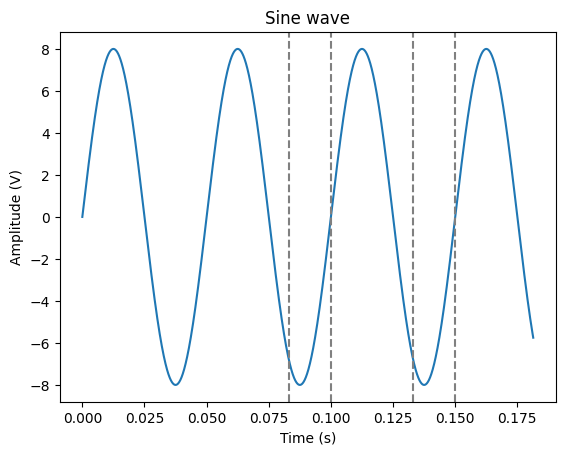

In [297]:

plot_create_sin(f, amplitude, fs_audio, N, bars=[0.1 - (maxlen/ fs_audio) ,0.1, 0.15 - (maxlen/ fs_audio), 0.15])

## 1.3. Pre-processing

#### 1.3.1. Normalisation

In [298]:
def get_max(s):
    max = float('-inf')
    for i in s:
        if i > max:
            max = i
    return max

def normalise(s):
    max = get_max(s)
    return s / max

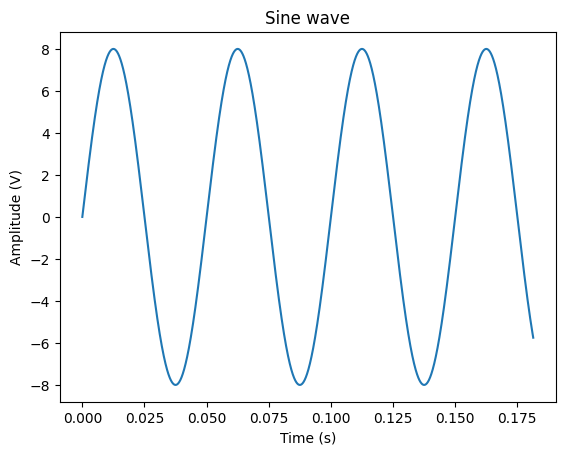

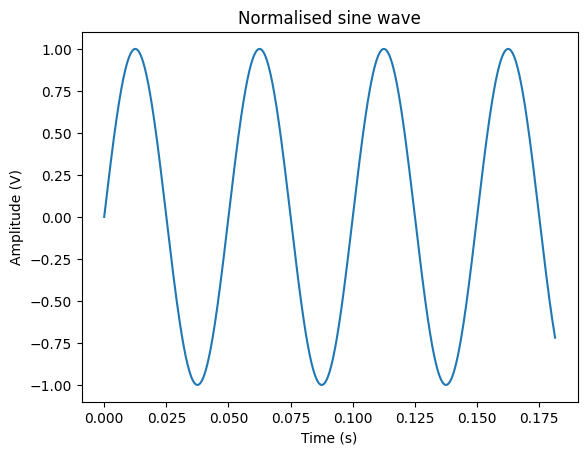

In [299]:
plot_sin(t, samples)
plot_sin(t, normalise(samples), title="Normalised sine wave")

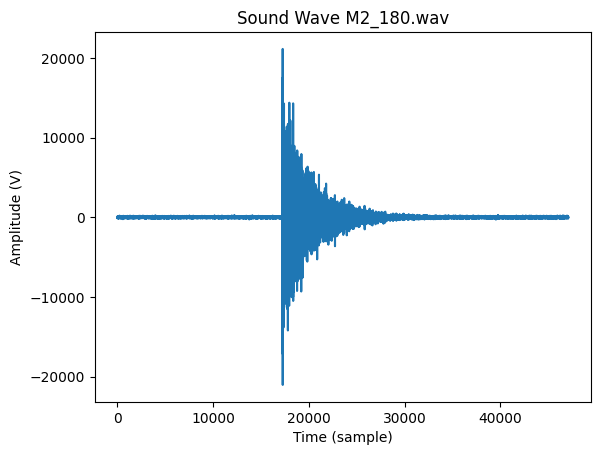

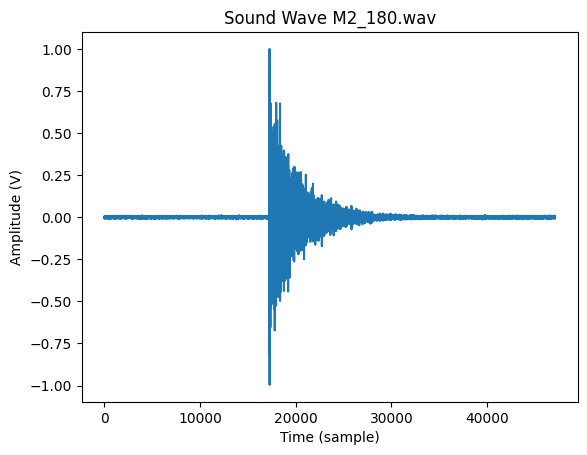

In [300]:
plot_sound_wave(data1, "M2_180.wav")
plot_sound_wave(normalise(data1), "M2_180.wav")

### 1.3.2 Downsampling

#### 1.3.2.1. Signal analysis

Text(0.5, 1.0, 'Spectogram of the file M1_0.wav')

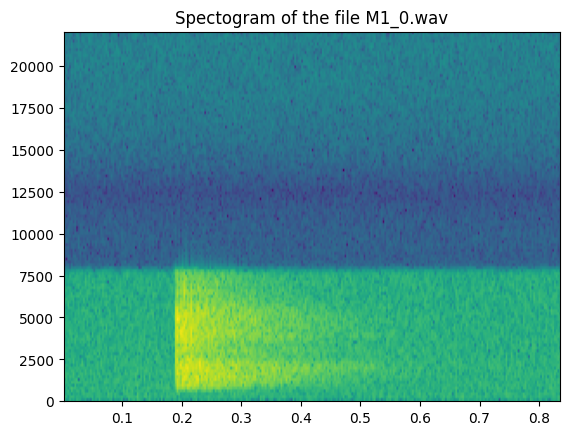

In [301]:
# Using that example, let's do the same for one of the audio file :)
f, data1 = read_wavefile("LocateClaps/M1_0.wav")
x = plt.specgram(normalise(data1), Fs=f)
plt.title("Spectogram of the file M1_0.wav")


#### 1.3.2.2 Anti-aliasing filter

In [302]:
def create_filter_cheby(wp, ws, gpass, gstop, fs):
    N, wn = signal.cheb1ord(wp, ws, gpass, gstop, fs=fs)
    return signal.cheby1(N, gpass, wn, "lowpass", False, fs=fs) # lowpass because we need to filter out frequencies above a certain threshold

def create_filter_cauer(wp, ws, gpass, gstop, fs):
    N, wn = signal.ellipord(wp, ws, gpass, gstop, fs=fs)
    return signal.ellip(N, gpass, gstop, wn, 'lowpass', False, fs=fs) 

In [303]:
(B_caueur, A_caueur) = create_filter_cauer(wp, ws,  rp, rs, 44100)

(B_cheby, A_cheby) = create_filter_cheby(wp, ws,  rp,  rs, 44100)

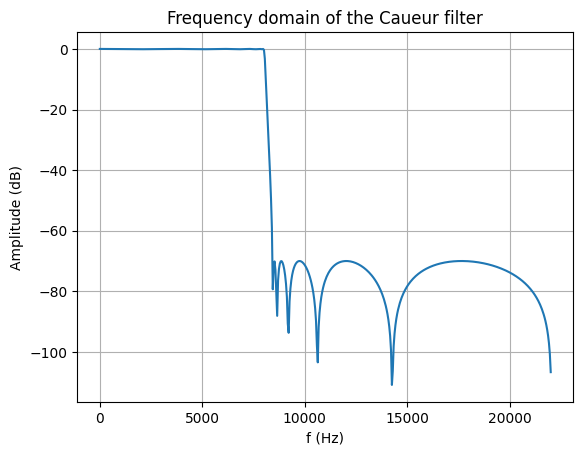

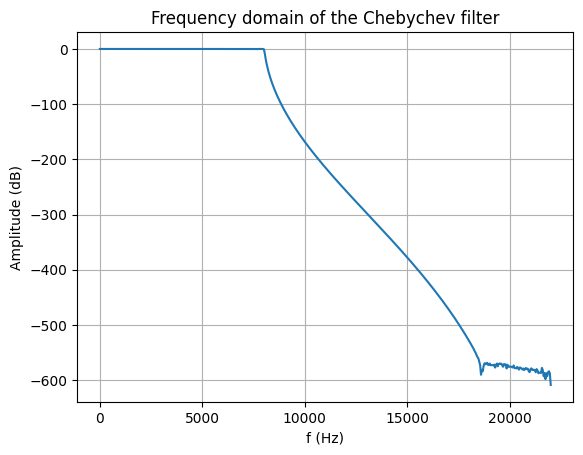

In [304]:
plot_filter(B_caueur, A_caueur, 44100, "Caueur")

plot_filter(B_cheby, A_cheby, 44100, "Chebychev")

##### 1.3.2.2.1 Use it on a signal wave with amplitude 1000V and frequency 8500 Hz and another sine wave with amplitude 20 and frequency 7500 Hz.

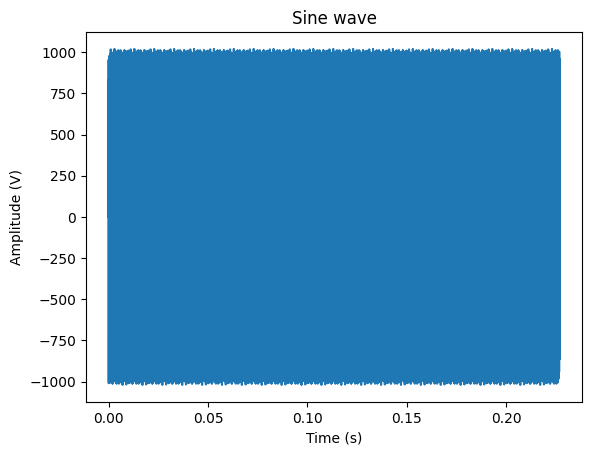

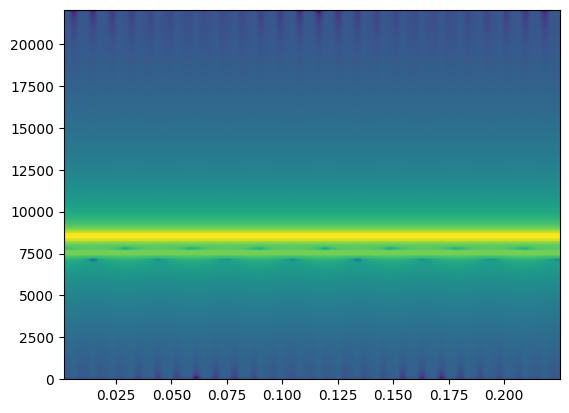

In [305]:
nb_of_samples = 10000

t, sin_samples = create_sine_wave(8500, 1000, fs_audio, nb_of_samples) 
sin_samples += create_sine_wave(7500, 20, fs_audio, nb_of_samples)[1]

plot_sin(t, sin_samples)
x = plt.specgram(sin_samples, Fs=f)

Apply it on the created signal

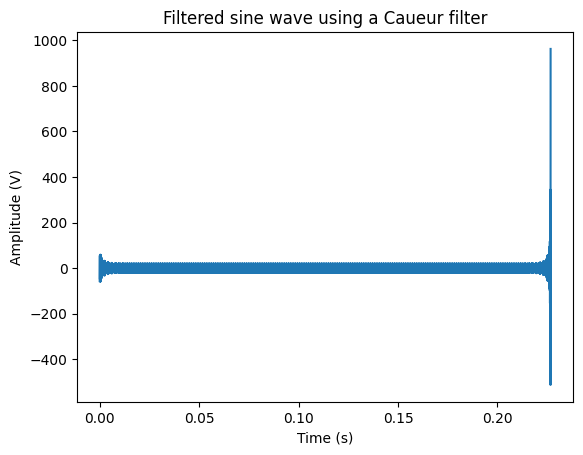

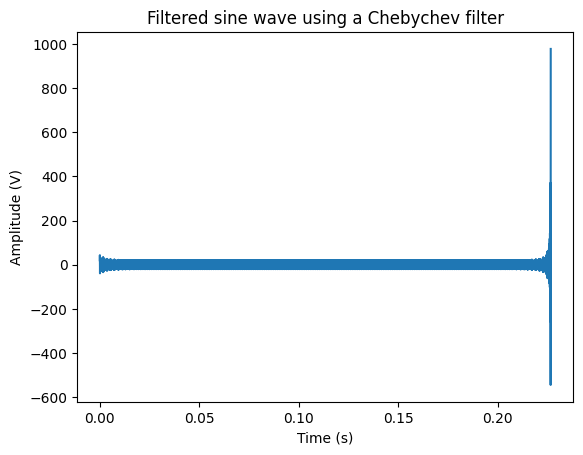

Text(0.5, 1.0, 'Spectogram of the filtered sine wave (using Caueur)')

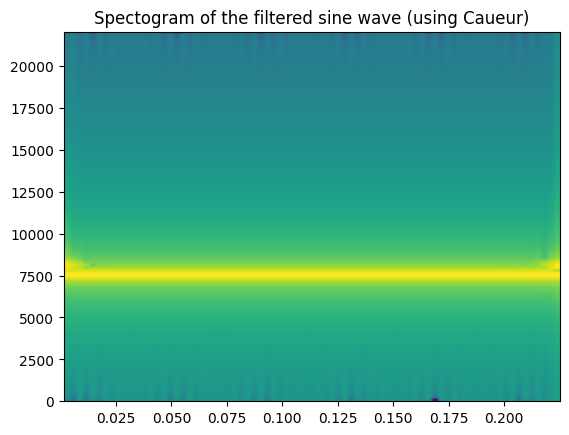

In [306]:
output_signal1 = signal.filtfilt(B_caueur, A_caueur,  sin_samples)

plot_sin(t, output_signal1, title="Filtered sine wave using a Caueur filter")

output_signal2 = signal.filtfilt(B_cheby, A_cheby,  sin_samples)


plot_sin(t, output_signal2, title="Filtered sine wave using a Chebychev filter")
x = plt.specgram(normalise(output_signal1), Fs=f)
plt.title("Spectogram of the filtered sine wave (using Caueur)")

#### 1.3.2.2. Decimation

In [307]:
def decimation(data, M=3):
    return data[::M]

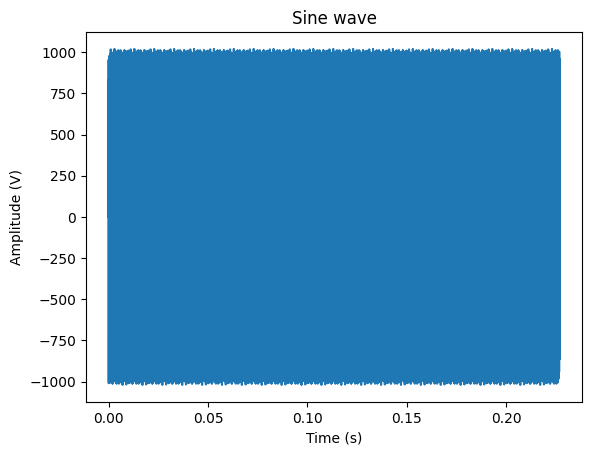

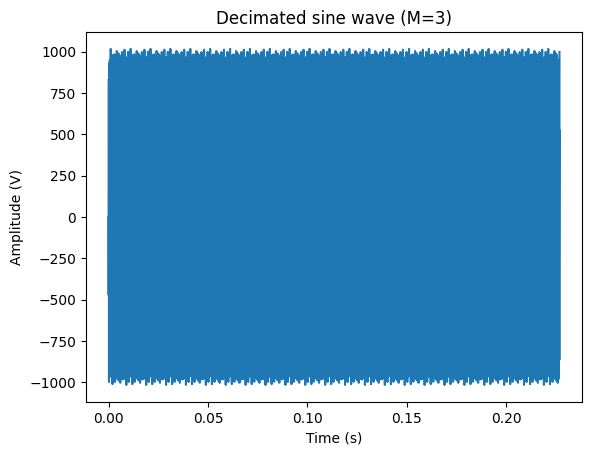

In [308]:
plot_sin(t, sin_samples)
plot_sin(t[::3], decimation(sin_samples, 3), title="Decimated sine wave (M=3)")

Show frequency domain after decimation **WITHOUT** using an anti-aliasing filter

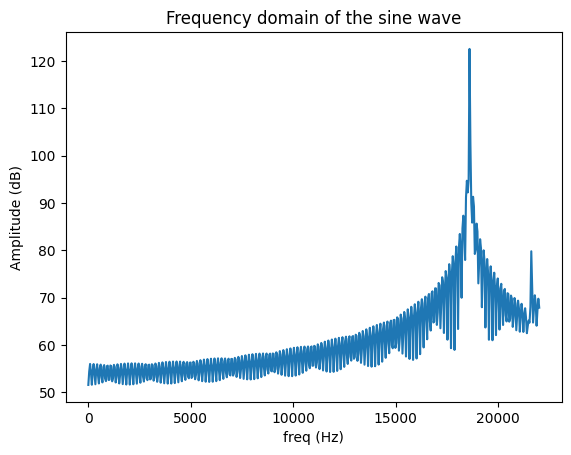

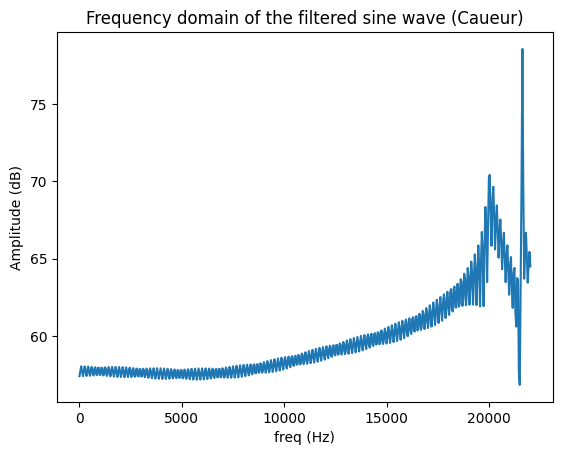

In [311]:
plot_freq_domain(decimation(sin_samples, 3), title="Frequency domain of the sine wave")

plot_freq_domain(decimation(signal.filtfilt(B_caueur, A_caueur,  sin_samples), 3), title="Frequency domain of the filtered sine wave (Caueur)")

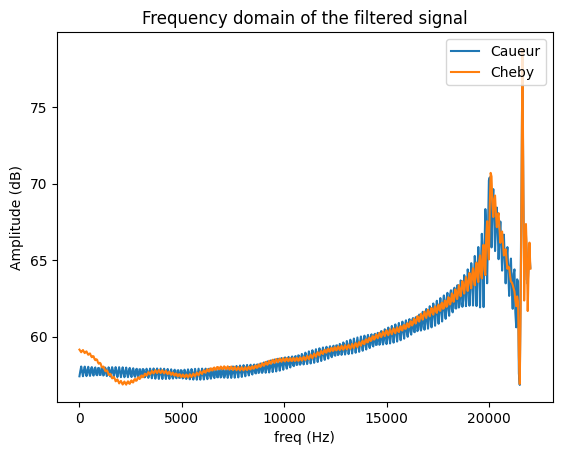

In [312]:
plot_freq_domain([decimation(output_signal1, 3),
                  decimation(output_signal2, 3)], True, labels=["Caueur", "Cheby"], title="Frequency domain of the filtered signal")